# Graph Neural Networks Baseline

In [1]:
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

In [3]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

In [4]:
from sklearn.model_selection import StratifiedKFold

## Load data

In [5]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [6]:
with open(f'{PICKLE_FOLDER}/timeseries.pickle', 'rb') as f:
    ts = pickle.load(f)

In [7]:
total_samples, total_brain_regions, ts_length = ts.shape

In [8]:
df_metadata = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)

In [9]:
df_metadata.head(2)

,age,sex,target
0,24.750,1,0
1,27.667,1,0


### Select connectivity dataset

In [10]:
THRESHOLD = 0.1
EDGE_FEATURES = 'binary'
CORR_TYPE = 'pearson'

In [11]:
with open(f'{PICKLE_FOLDER}/fc-{CORR_TYPE}-th-{THRESHOLD}-{EDGE_FEATURES}.pickle', 'rb') as f:
    edge_index_matrix = pickle.load(f)

In [12]:
edge_index_matrix.shape

(190, 90, 90)

## Split data

In [13]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)

In [50]:
train_indices = list(set(range(total_samples)) - set(test_indices))

In [51]:
train_targets = df_metadata.iloc[train_indices]["target"].reset_index(drop=True)

## Prepare data

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### `Data` object fields

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

In [67]:
dataset = [Data(
    x=torch.from_numpy(ts[i]).to(torch.float32),  
    edge_index=torch.from_numpy(np.asarray(np.nonzero(edge_index_matrix[i]))).to(torch.int64),
    y=torch.tensor([target], dtype=torch.int64)
).to(device) for target, i in zip(train_targets, train_indices)]

In [68]:
print('Data object')
print(f'Edge matrix: {dataset[0].edge_index.shape}')
print(f'Node features: {dataset[0].x.shape}')
print(f'Target: {dataset[0].y.shape}')

Data object
Edge matrix: torch.Size([2, 366])
Node features: torch.Size([90, 400])
Target: torch.Size([1])


## Define model

In [69]:
class BaselineGCN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super(BaselineGCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(ts_length, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.fc1 = Linear(hidden_channels, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc1(x)     # CELoss already incorporates `log_softmax`.
        
        return x

In [70]:
net = BaselineGCN(hidden_channels=64)
net.to(device)

BaselineGCN(
  (conv1): GCNConv(400, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)

## Train model

In [71]:
skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)

In [72]:
EPOCHS = 100

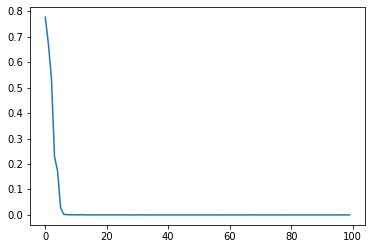

Accuracy: 42.86 %
Precision: 46.51 %
Recall: 54.05 %
TP: 20, TN: 10, FP: 23, FN: 17
Finished fold #0



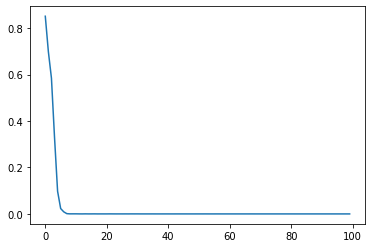

Accuracy: 48.57 %
Precision: 52.50 %
Recall: 55.26 %
TP: 21, TN: 13, FP: 19, FN: 17
Finished fold #1

Finished training


In [75]:
for kfold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):
    
    # Init model.
    net = BaselineGCN(hidden_channels=64).to(device)
    optimizr = torch.optim.Adam(net.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    net.train()

    # Prepare data.
    X_train = [dataset[i] for i in train_index]
    X_val = [dataset[i] for i in val_index]
    
    trainloader = DataLoader(X_train, batch_size=4, shuffle=True)
    valloader = DataLoader(X_val, batch_size=4, shuffle=False)

    # Train.
    epoch_losses = []
    for epoch in range(EPOCHS):
        running_loss = 0.
        epoch_size = 0
        
        for data in trainloader:
            optimizr.zero_grad()

            outputs = net(data)
            
            loss = criterion(outputs, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizr.step()

            running_loss += loss.item()
            epoch_size += 1

        epoch_losses.append(running_loss / epoch_size)

    # Plot training loss.
    plt.plot(range(EPOCHS), epoch_losses)
    plt.show()
    
    # Evaluate fold.
    tp, tn, fp, fn = 0, 0, 0, 0
    total = 0

    with torch.no_grad():
        net.eval()

        for data in valloader:
            outputs = net(data)

            predicted = outputs.argmax(dim=1)

            total += data.y.size(0)

            labels = data.y.view(-1)

            pred_positives = predicted == 1
            label_positives = labels == 1

            tp += (pred_positives & label_positives).sum().item()
            tn += (~pred_positives & ~label_positives).sum().item()
            fp += (pred_positives & ~label_positives).sum().item()
            fn += (~pred_positives & label_positives).sum().item()

    print('===========================================')
    print(f'Accuracy: {(tp + tn) / total * 100:.2f} %')
    print(f'Precision: {tp / (tp + fp) * 100:.2f} %')
    print(f'Recall: {tp / (tp + fn) * 100:.2f} %')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print('===========================================')

    print(f'Finished fold #{kfold}\n')

print('Finished training')